# Выбор локации для скважины

## Описание и цель проекта
Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- в избранном регионе ищут месторождения, для каждого определяют значения признаков;
- строят модель и оценивают объём запасов;
- выбирают месторождения с самым высокими оценками значений, количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install shap  -q

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap, phik

from numpy.random import RandomState

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

RANDOM_STATE = 42
BUDGET = 10_000_000_000 #бюджет для региона
COUNT = 200 #число скважин к разработке
PRICE = 450000 #цена за 1000 баррелей

In [2]:
plt.rcParams["figure.figsize"] = (10,5)
pd.set_option('display.max_rows', None)  # Отображать все строки
pd.set_option('display.max_columns', None)  # Отображать все столбцы

## Загрузка и подготовка данных
Данные геологоразведки трёх регионов находятся в файлах: 
 - /datasets/geo_data_0.csv
 - /datasets/geo_data_1.csv
 - /datasets/geo_data_2.csv

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

### Загрузим файл geo_data_0, выполним предподготовку и исследовательский анализ данных

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv') #чтение файла geo_data_0.csv  
display (geo_data_0.head()) #вывод первых пяти строк
print (geo_data_0.info()) #вывод общей информации о DataFrame

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Нулевых данных нет, переименование столбцов не требуется, проверим на наличие дубликатов.

In [4]:
print('Количество дубликатов в таблице geo_data_0:', geo_data_0.duplicated().sum())

Количество дубликатов в таблице geo_data_0: 0


Явных дубликатов нет, попробуем выявить неявные дубликаты. Для этого проверим число уникальных id в таблице.

In [5]:
print ('Количество id в таблице geo_data_0:', geo_data_0['id'].nunique())

Количество id в таблице geo_data_0: 99990


Выведем дубликаты.

In [6]:
print(geo_data_0[geo_data_0.duplicated('id', keep=False)].sort_values('id'))


          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.630479   93

Будем считать достоверными данные те, что введены позже (то есть оставим последнюю "версию" дубликата).

In [7]:
geo_data_0 = geo_data_0.drop_duplicates(subset='id', keep='last')
print (geo_data_0.info()) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
None


Построим графики для каждого признака и матрицу корреляции признаков. Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [8]:
info_geo_data_0 = geo_data_0.drop(columns=['id']).describe().T
info_geo_data_0['norm_min']=info_geo_data_0['25%']-1.5*info_geo_data_0['std']
info_geo_data_0['norm_max']=info_geo_data_0['75%']+1.5*info_geo_data_0['std']
info_geo_data_0

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
f0,99990.0,0.500412,0.871867,-1.408605,-0.072683,0.502340,1.073626,2.362331,-1.380483,2.381426
f1,99990.0,0.250149,0.504434,-0.848218,-0.200877,0.250252,0.700654,1.343769,-0.957527,1.457304
f2,99990.0,2.502656,3.248155,-12.088328,0.287887,2.516005,4.714970,16.003790,-4.584346,9.587202
product,99990.0,92.499482,44.289431,0.000000,56.496838,91.849972,128.564269,185.364347,-9.937309,194.998415


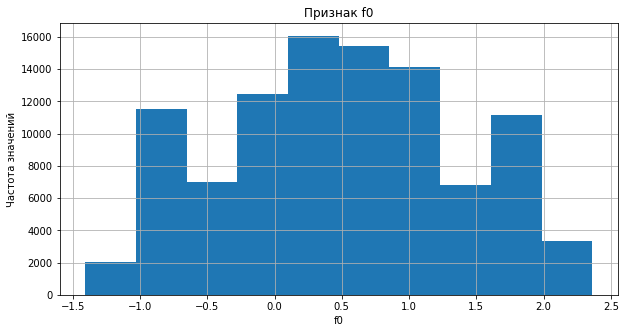

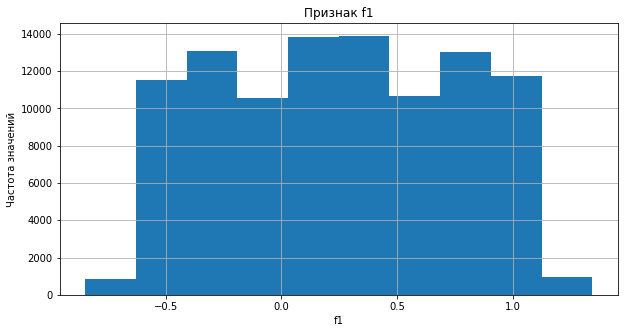

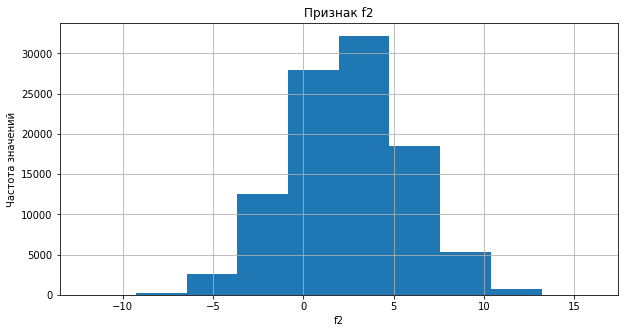

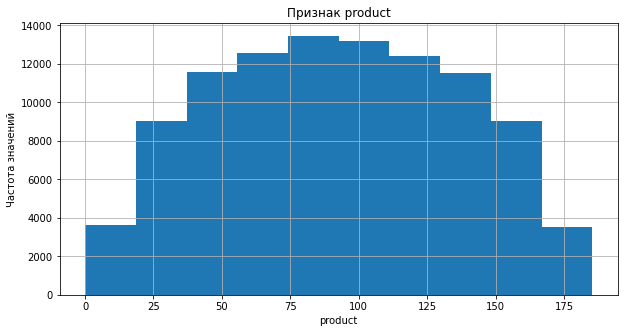

In [9]:
# определяем количественные признаки
numerical_features = geo_data_0.select_dtypes(include=['float64']).columns 

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(geo_data_0[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  

Аномальных значений не зафиксировано. Рассчитаем коэффициенты корреляции Фи (так как нужно отобразить взаимосвязь между категориальными и интервальными признаками, а корреляция Пирсона не подходит для категориальных признаков).

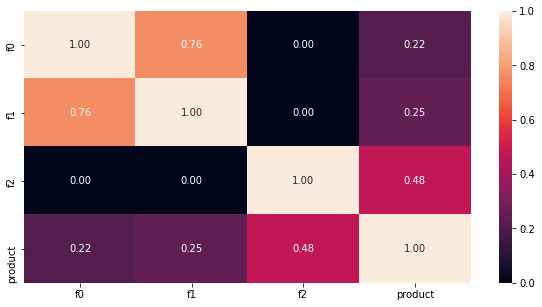

In [10]:
sns.heatmap(geo_data_0.drop(columns=['id']).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']), annot=True, fmt='.2f')
plt.show()

Мультиколлинеарности нет. Посмотрим на графики распределения признаков в разрезе целевого признака.

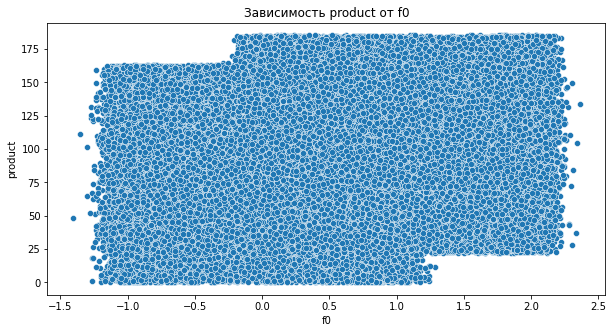

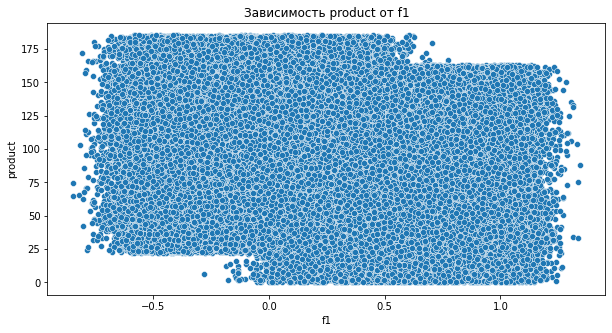

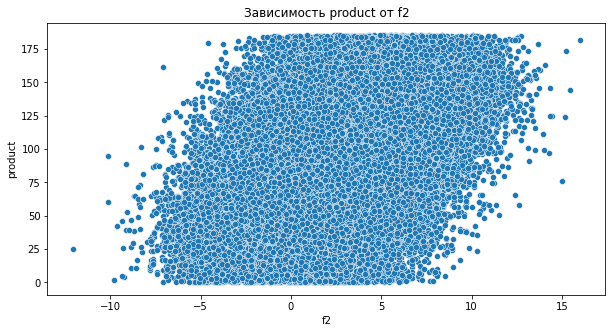

In [11]:
# определяем количественные признаки, исключив целевой product
numerical_features = ['f0', 'f1', 'f2']

for col in numerical_features:
    sns.scatterplot(x=col, y='product', data=geo_data_0)
    plt.title(f'Зависимость product от {col}')
    plt.show()
    

Признак product явно линейно зависит от f2, с остальными признаками сложнее.


### Загрузим файл geo_data_1, выполним предподготовку и исследовательский анализ данных

In [12]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv') #чтение файла geo_data_1.csv  
display (geo_data_1.head()) #вывод первых пяти строк
print (geo_data_1.info()) #вывод общей информации о DataFrame

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Нулевых данных нет, переименование столбцов не требуется, проверим на наличие дубликатов.

In [13]:
print('Количество дубликатов в таблице geo_data_1:', geo_data_1.duplicated().sum())

Количество дубликатов в таблице geo_data_1: 0


Явных дубликатов нет, попробуем выявить неявные дубликаты. Для этого проверим число уникальных id в таблице.

In [14]:
print ('Количество id в таблице geo_data_1:', geo_data_1['id'].nunique())

Количество id в таблице geo_data_1: 99996


Выведем дубликаты.

In [15]:
print(geo_data_1[geo_data_1.duplicated('id', keep=False)].sort_values('id'))

          id         f0         f1        f2     product
5849   5ltQ6  -3.435401 -12.296043  1.999796   57.085625
84461  5ltQ6  18.213839   2.191999  3.993869  107.813044
1305   LHZR0  11.170835  -1.945066  3.002872   80.859783
41906  LHZR0  -8.989672  -4.286607  2.009139   57.085625
2721   bfPNe  -9.494442  -5.463692  4.006042  110.992147
82178  bfPNe  -6.202799  -4.820045  2.995107   84.038886
47591  wt4Uk  -9.091098  -8.109279 -0.002314    3.179103
82873  wt4Uk  10.259972  -9.376355  4.994297  134.766305


Будем считать достоверными данные те, что введены позже (то есть оставим последнюю "версию" дубликата).

In [16]:
geo_data_1 = geo_data_1.drop_duplicates(subset='id', keep='last')
print (geo_data_1.info()) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
None


Построим графики для каждого признака и матрицу корреляции признаков. Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [17]:
info_geo_data_1 = geo_data_1.drop(columns=['id']).describe().T
info_geo_data_1['norm_min']=info_geo_data_1['25%']-1.5*info_geo_data_1['std']
info_geo_data_1['norm_max']=info_geo_data_1['75%']+1.5*info_geo_data_1['std']
info_geo_data_1

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
f0,99996.0,1.141450,8.965922,-31.609576,-6.298525,1.153190,8.621015,29.421755,-19.747407,22.069898
f1,99996.0,-4.796493,5.119900,-26.358598,-8.267985,-4.813005,-1.332704,18.734063,-15.947835,6.347146
f2,99996.0,2.494551,1.703579,-0.018144,1.000021,2.011479,3.999904,5.019721,-1.555347,6.555273
product,99996.0,68.825232,45.944649,0.000000,26.953261,57.085625,107.813044,137.945408,-41.963712,176.730017


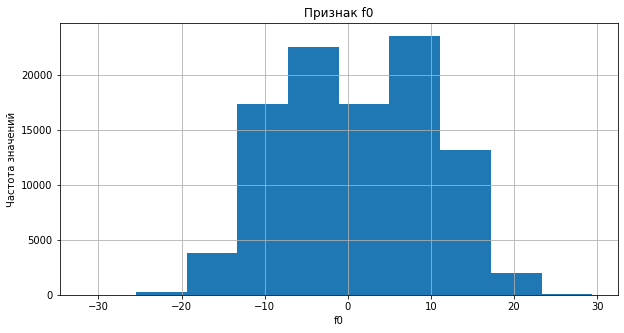

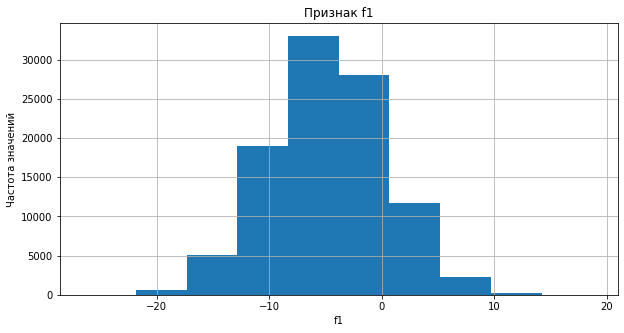

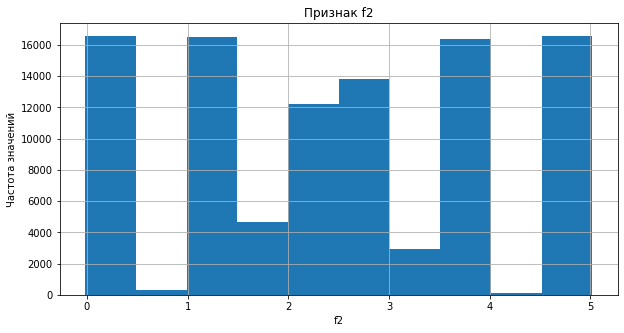

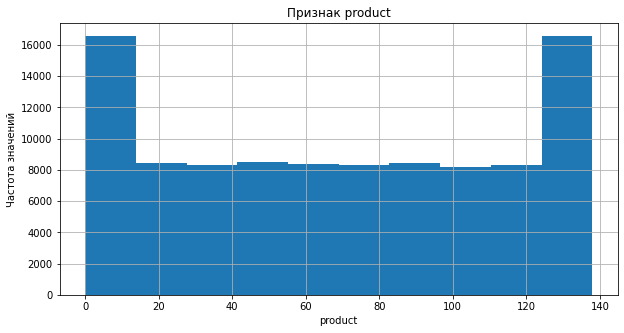

In [18]:
# определяем количественные признаки
numerical_features = geo_data_1.select_dtypes(include=['float64']).columns 

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(geo_data_1[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  

Рассчитаем коэффициенты корреляции Фи (так как нужно отобразить взаимосвязь между категориальными и интервальными признаками, а корреляция Пирсона не подходит для категориальных признаков).

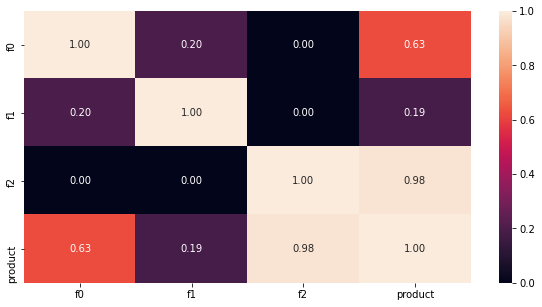

In [19]:
sns.heatmap(geo_data_1.drop(columns=['id']).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']), annot=True, fmt='.2f')
plt.show()

Очень высокий коэффициент коллинеарности у product с f2, но это корреляция между исходным признаком и целевым, к тому же в условии задачи сказано, что все признаки важны, следовательно, мы не можем их удалять.
Посмотрим на графики распределения признаков в разрезе целевого признака.

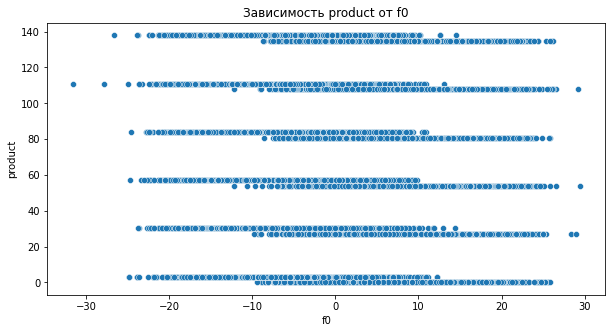

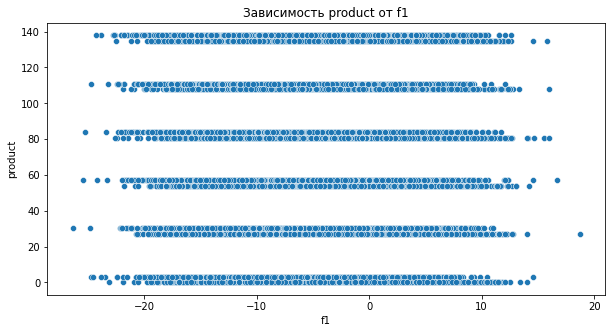

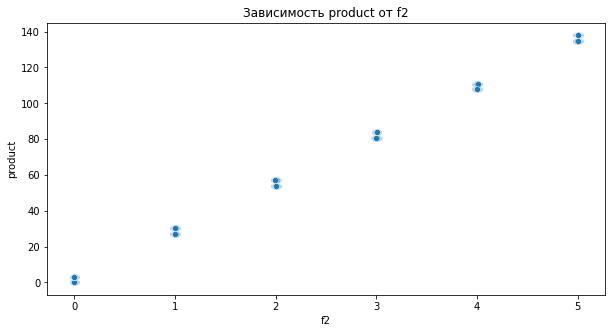

In [20]:
# определяем количественные признаки, исключив целевой product
numerical_features = ['f0', 'f1', 'f2']

for col in numerical_features:
    sns.scatterplot(x=col, y='product', data=geo_data_1)
    plt.title(f'Зависимость product от {col}')
    plt.show()
    

И снова признак product явно линейно зависит от f2.

### Загрузим файл geo_data_2, выполним предподготовку и исследовательский анализ данных


In [21]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv') #чтение файла geo_data_2.csv  
display (geo_data_2.head()) #вывод первых пяти строк
print (geo_data_2.info()) #вывод общей информации о DataFrame

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Нулевых данных нет, переименование столбцов не требуется, проверим на наличие дубликатов.

In [22]:
print('Количество дубликатов в таблице geo_data_2:', geo_data_2.duplicated().sum())

Количество дубликатов в таблице geo_data_2: 0


Явных дубликатов нет, попробуем выявить неявные дубликаты. Для этого проверим число уникальных id в таблице.

In [23]:
print ('Количество id в таблице geo_data_2:', geo_data_2['id'].nunique())

Количество id в таблице geo_data_2: 99996


Выведем дубликаты.

In [24]:
print(geo_data_2[geo_data_2.duplicated('id', keep=False)].sort_values('id'))

          id        f0        f1        f2     product
45404  KUPhW  0.231846 -1.698941  4.990775   11.716299
55967  KUPhW  1.211150  3.176408  5.543540  132.831802
11449  VF7Jo  2.122656 -0.858275  5.746001  181.716817
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420
44378  Vcm5J -1.229484 -2.439204  1.222909  137.968290
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572
28039  xCHr8  1.633027  0.368135 -2.378367    6.120525
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641


Будем считать достоверными данные те, что введены позже (то есть оставим последнюю "версию" дубликата).

In [25]:
geo_data_2 = geo_data_2.drop_duplicates(subset='id', keep='last')
print (geo_data_2.info()) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
None


Построим графики для каждого признака и матрицу корреляции признаков. Выведем для удобства числовое описание диаграммы размаха (добавив в таблицу границы нормальных значений).

In [26]:
info_geo_data_2 = geo_data_2.drop(columns=['id']).describe().T
info_geo_data_2['norm_min']=info_geo_data_2['25%']-1.5*info_geo_data_2['std']
info_geo_data_2['norm_max']=info_geo_data_2['75%']+1.5*info_geo_data_2['std']
info_geo_data_2

,count,mean,std,min,25%,50%,75%,max,norm_min,norm_max
f0,99996.0,0.001995,1.732054,-8.760004,-1.162288,0.009411,1.158477,7.238262,-3.760370,3.756559
f1,99996.0,-0.002034,1.730424,-7.084020,-1.174805,-0.009433,1.163760,7.844801,-3.770440,3.759396
f2,99996.0,2.495132,3.473453,-11.970335,0.130359,2.484236,4.858720,16.739402,-5.079821,10.068900
product,99996.0,95.000425,44.748112,0.000000,59.452094,94.925613,130.590822,190.029838,-7.670074,197.712990


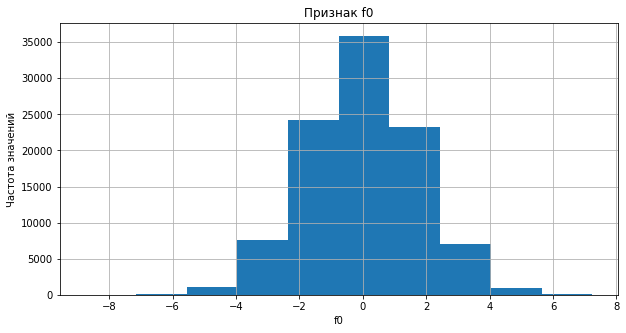

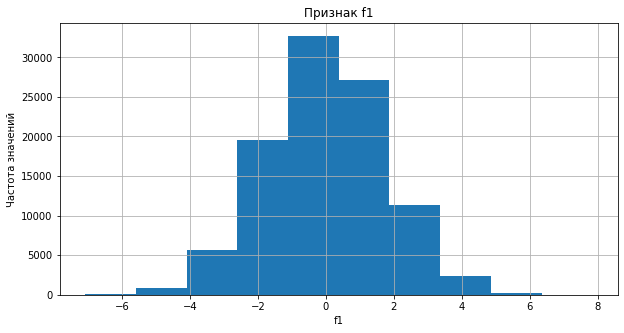

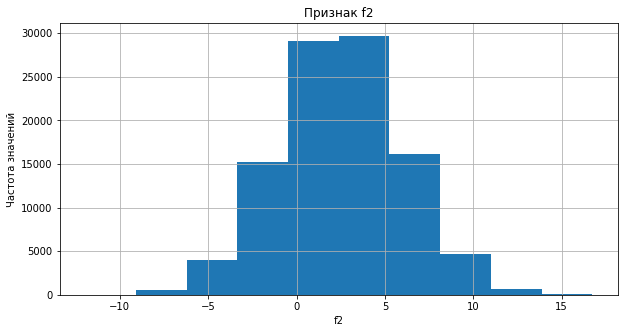

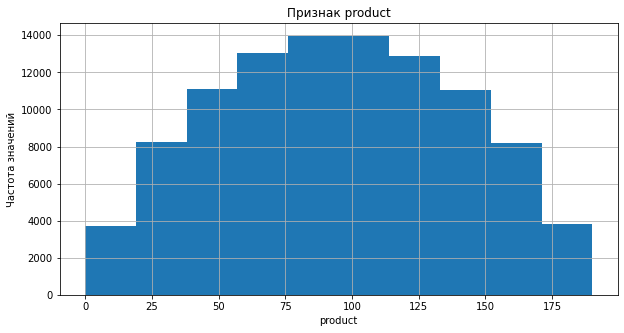

In [27]:
# определяем количественные признаки
numerical_features = geo_data_2.select_dtypes(include=['float64']).columns 

# построение графиков для количественных признаков
for i, feature in enumerate(numerical_features):
    pd.Series(geo_data_2[feature]).hist()
    plt.title(f'Признак {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота значений')
    plt.show()  

Аномальных значений не зафиксировано. Рассчитаем коэффициенты корреляции Фи (так как нужно отобразить взаимосвязь между категориальными и интервальными признаками, а корреляция Пирсона не подходит для категориальных признаков).

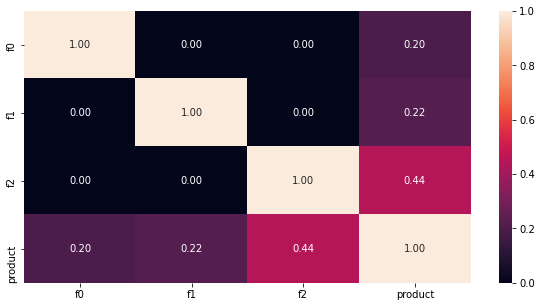

In [28]:
sns.heatmap(geo_data_2.drop(columns=['id']).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']), annot=True, fmt='.2f')
plt.show()

Мультиколлинеарности нет. Посмотрим на графики распределения признаков в разрезе целевого признака.

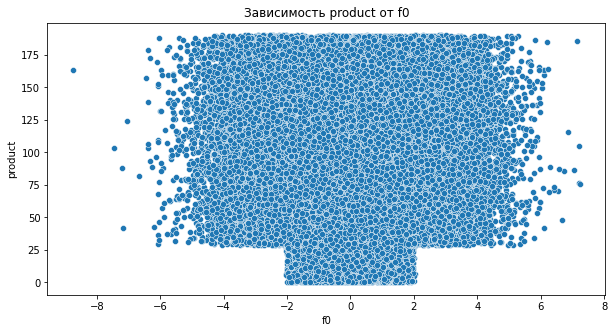

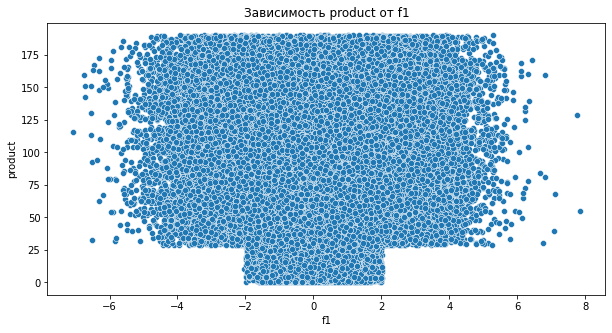

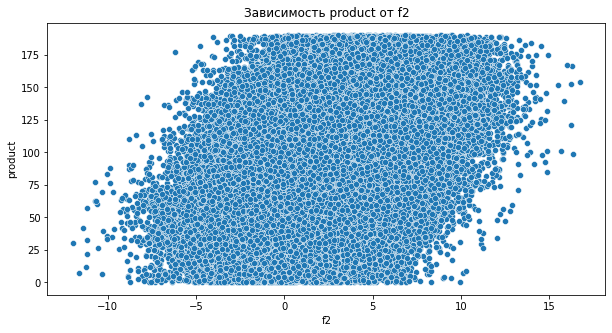

In [29]:
# определяем количественные признаки, исключив целевой product
numerical_features = ['f0', 'f1', 'f2']

for col in numerical_features:
    sns.scatterplot(x=col, y='product', data=geo_data_2)
    plt.title(f'Зависимость product от {col}')
    plt.show()
    

Признак product линейно зависит от f2.

### Промежуточный вывод
На данном этапе выполнена загрузка данных, проверка данных на наличие явных и неявных дубликатов (удаление дубликатов при необходимости), а также проведен исследовательский анализ данных.
Масштабирование признаков выполним после разделения выборки на тестовую и валидационную.

## Обучение и проверка модели

Столбец id не участвует в обучении модели, удалим его и проверим, не появилось ли у нас дубликатов.

In [30]:
geo_data_0_without_id = geo_data_0.drop(['id'], axis=1)
print('Количество дубликатов в таблице geo_data_0_without_id:', geo_data_0_without_id.duplicated().sum())
geo_data_1_without_id = geo_data_1.drop(['id'], axis=1)
print('Количество дубликатов в таблице geo_data_1_without_id:', geo_data_1_without_id.duplicated().sum())
geo_data_2_without_id = geo_data_2.drop(['id'], axis=1)
print('Количество дубликатов в таблице geo_data_2_without_id:', geo_data_2_without_id.duplicated().sum())


Количество дубликатов в таблице geo_data_0_without_id: 0
Количество дубликатов в таблице geo_data_1_without_id: 0
Количество дубликатов в таблице geo_data_2_without_id: 0


Дубликатов после удаления столбца id нет, идем дальше.

### Функция обучения модели
Так как нам потребуется выполнять одни и те же действия с данными по трем регионам, создадим функцию обучения модели, включая масштабирование количественных признаков (категориальных признаков у нас нет).

In [31]:
# функция обучения модели, включая масштабирование количественных признаков
def model_training (X, y, quantitative_features):
    # разбиваем данные на тренировочную и валидационную выборки
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

    # масштабируем количественные признаки с помощью StandardScaler
    scaler = StandardScaler()
    X_train_scaler = scaler.fit_transform(X_train[quantitative_features])
    X_val_scaler = scaler.transform(X_val[quantitative_features])

    X_train = pd.DataFrame(X_train_scaler, columns=quantitative_features)
    X_val = pd.DataFrame(X_val_scaler, columns=quantitative_features)

    # Обучим модель линейной регрессии на подготовленных данных
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    # получим предсказания модели на валидационных данных 
    predictions = model_lr.predict(X_val)
    return X_train, X_val, y_train, y_val, predictions, model_lr, scaler

In [32]:
quantitative_features = ['f0', 'f1', 'f2'] # эти признаки одинаковы для трех регионов

### Таблица geo_data_0

In [33]:
# Сохраняем id перед удалением
ids = geo_data_0['id']
# отбираем входные признаки
X_0 = geo_data_0.drop(['id','product'], axis=1)
# определяем целевой признак
y_0 = geo_data_0['product']


X_train_0, X_val_0, y_train_0, y_val_0, predictions_0, model_lr_0, scaler_0 = model_training (X_0, y_0, quantitative_features)
print ("X_train_0 =", X_train_0.shape)
print ("X_val_0 =", X_val_0.shape)

# Восстанавливаем id в валидационной выборке
X_val_0['id'] = ids.iloc[X_val_0.index].values

# Добавляем правильные ответы и предсказания к валидационной выборке
X_val_0['actual'] = y_val_0.values
X_val_0['predicted'] = predictions_0

# Вычисляем средний запас предсказанного сырья
mean_predicted_reserve = X_val_0['predicted'].mean()

# Вычисляем RMSE модели
rmse = mean_squared_error(X_val_0['actual'], X_val_0['predicted']) ** 0.5

# Выводим результаты
print(f"Средний запас предсказанного сырья: {mean_predicted_reserve:.2f}")
print(f"RMSE модели: {rmse:.2f}")

# Просмотр первых строк итогового DataFrame
print(X_val_0.head())

X_train_0 = (74992, 3)
X_val_0 = (24998, 3)
Средний запас предсказанного сырья: 92.37
RMSE модели: 37.81
         f0        f1        f2     id      actual   predicted
0  1.052584 -0.704877 -0.709058  txEyH   46.415405   85.823243
1  0.393894 -0.683082  0.975410  2acmU   77.332426  119.653794
2  1.435595 -0.767677  0.668202  409Wp  149.721614  117.029515
3 -0.215791 -1.159100 -0.994038  iJLyR   93.439209   78.875767
4 -0.543255 -0.463702  0.127819  Xdl7t  127.207120   96.896620


RMSE модели очень велика, но это логично - данные подготовить у меня так и не получилось.

### Таблица geo_data_1

In [34]:
# Сохраняем id перед удалением
ids = geo_data_1['id']
# отбираем входные признаки
X_1 = geo_data_1.drop(['id','product'], axis=1)
# определяем целевой признак
y_1 = geo_data_1['product']

X_train_1, X_val_1, y_train_1, y_val_1, predictions_1, model_lr_1, scaler_1 = model_training (X_1, y_1, quantitative_features)
print ("X_train_1 =", X_train_1.shape)
print ("X_val_1 =", X_val_1.shape)

# Восстанавливаем id в валидационной выборке
X_val_1['id'] = ids.iloc[X_val_1.index].values

# Добавляем правильные ответы и предсказания к валидационной выборке
X_val_1['actual'] = y_val_1.values
X_val_1['predicted'] = predictions_1

# Вычисляем средний запас предсказанного сырья
mean_predicted_reserve = X_val_1['predicted'].mean()

# Вычисляем RMSE модели
rmse = mean_squared_error(X_val_1['actual'], X_val_1['predicted']) ** 0.5

# Выводим результаты
print(f"Средний запас предсказанного сырья: {mean_predicted_reserve:.2f}")
print(f"RMSE модели: {rmse:.2f}")

# Просмотр первых строк итогового DataFrame
print(X_val_1.head())

X_train_1 = (74997, 3)
X_val_1 = (24999, 3)
Средний запас предсказанного сырья: 69.04
RMSE модели: 0.89
         f0        f1        f2     id     actual  predicted
0 -0.498614 -0.939555 -1.459562  kBEdx   3.179103   2.435587
1  2.218585  1.122901 -0.876018  62mP7  26.953261  25.490599
2  0.107963  0.609130 -0.283706  vyE1P  53.906522  55.505843
3  1.041296  0.993595 -0.868001  KcrkZ  26.953261  27.401977
4  1.310225 -0.533707 -1.455428  AHL4O   0.000000   0.231574


Здесь RMSE модели уже лучше, но данные все-таки надо привести в порядок.

### Таблица geo_data_2

In [35]:
# Сохраняем id перед удалением
ids = geo_data_2['id']
# отбираем входные признаки
X_2 = geo_data_2.drop(['id','product'], axis=1)
# определяем целевой признак
y_2 = geo_data_2['product']


X_train_2, X_val_2, y_train_2, y_val_2, predictions_2, model_lr_2, scaler_2 = model_training (X_2, y_2, quantitative_features)
print ("X_train_2 =", X_train_2.shape)
print ("X_val_2 =", X_val_2.shape)

# Восстанавливаем id в валидационной выборке
X_val_2['id'] = ids.iloc[X_val_2.index].values

# Добавляем правильные ответы и предсказания к валидационной выборке
X_val_2['actual'] = y_val_2.values
X_val_2['predicted'] = predictions_2

# Вычисляем средний запас предсказанного сырья
mean_predicted_reserve = X_val_2['predicted'].mean()

# Вычисляем RMSE модели
rmse = mean_squared_error(X_val_2['actual'], X_val_2['predicted']) ** 0.5

# Выводим результаты
print(f"Средний запас предсказанного сырья: {mean_predicted_reserve:.2f}")
print(f"RMSE модели: {rmse:.2f}")

# Просмотр первых строк итогового DataFrame
print(X_val_2.head())


X_train_2 = (74997, 3)
X_val_2 = (24999, 3)
Средний запас предсказанного сырья: 94.92
RMSE модели: 40.14
         f0        f1        f2     id      actual   predicted
0  0.657497 -1.413255 -0.956506  fwXo0  131.922590   76.062691
1  1.178149 -0.825497 -0.254207  WJtFt  165.456075   90.061111
2 -0.434103 -0.057520  1.279119  ovLUW  102.105539  120.630616
3  0.289036 -1.108269 -1.597145  q6cA6   34.079047   63.224541
4 -1.270671  1.734519  2.314995  WPMUX  138.077543  141.179707


Снова RMSE модели очень велика, думаю, снова проблема в данных.

### Промежуточный вывод
На данном этапе обучена и проверена модель для каждого региона.

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [36]:
#рассчитаем достаточный объем сырья для безубыточной разработки новой скважины
volume = BUDGET/(COUNT*PRICE)

print(f"Достаточный объем сырья: {volume:.2f}")

Достаточный объем сырья: 111.11


### Промежуточный вывод
Достаточный объем сырья для безубыточной разработки новой скважины выше средних запасов в каждом регионе.
Но мы будем выбирать топ-200 скважин, поэтому и показатели среднего будут выше.

## Расчёт прибыли и рисков 

Напишем функцию, рассчитывающую прибыль по выбранным скважинам.

In [37]:
def calculate_profit(df, count, price, budget):
    
    # Отбираем 200 скважин с наибольшими предсказанными значениями
    top_selected = df.nlargest(count, 'predicted')

    # Суммируем объём сырья среди отобранных скважин
    total_oil = top_selected['actual'].sum()
    # Рассчитываем доход
    revenue = total_oil * price

    # Вычитаем бюджет (получаем прибыль)
    profit = revenue - budget

    return profit


Посчитаем риски и прибыль для каждого региона.

In [38]:
def bootstrap_profit(df, count, price, budget):
 
    profits = []
    state = np.random.RandomState(12345)
    for i in range(1000):
        sample_df = df.sample(n=500, replace=True, random_state=state)
        profit = calculate_profit(sample_df, COUNT, PRICE, BUDGET)
        profits.append(profit)
    
    profits = pd.Series(profits)
    mean_profit = profits.mean()
    lower = round(profits.quantile(0.025), 2)
    upper = round(profits.quantile(0.975), 2)
    risk = np.mean(profits < 0)
    
    return mean_profit, (lower, upper), risk

mean_profit_0, di_0, risk_0 = bootstrap_profit(X_val_0, COUNT, PRICE, BUDGET)
mean_profit_1, di_1, risk_1 = bootstrap_profit(X_val_1, COUNT, PRICE, BUDGET)
mean_profit_2, di_2, risk_2 = bootstrap_profit(X_val_2, COUNT, PRICE, BUDGET)

print(f"Регион 0: \n Средняя прибыль = {mean_profit_0:.2f} руб., \n 95%-й ДИ = {di_0}, \n Риск убытков = {risk_0:.2%}")
print(f"Регион 1: \n Средняя прибыль = {mean_profit_1:.2f} руб., \n 95%-й ДИ = {di_1}, \n Риск убытков = {risk_1:.2%}")
print(f"Регион 2: \n Средняя прибыль = {mean_profit_2:.2f} руб., \n 95%-й ДИ = {di_2}, \n Риск убытков = {risk_2:.2%}")

Регион 0: 
 Средняя прибыль = 397966606.96 руб., 
 95%-й ДИ = (-107956506.89, 899629462.1), 
 Риск убытков = 7.60%
Регион 1: 
 Средняя прибыль = 455686834.75 руб., 
 95%-й ДИ = (36527757.14, 841661057.38), 
 Риск убытков = 1.70%
Регион 2: 
 Средняя прибыль = 351291974.38 руб., 
 95%-й ДИ = (-172969895.52, 831517539.89), 
 Риск убытков = 9.10%


После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбираем регион с наибольшей средней прибылью - получаем второй регион (файл geo_data_0).

## Итоговый вывод

В данном проекте нам предстояло решить, где добывающей компании «ГлавРосГосНефть» бурить новую скважину.

Были предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Для этого:
 - были загружены и проанализированы полученные данные
 - обучена и проверена модель машинного обучения, которая должна помочь определить регион, где добыча принесёт наибольшую прибыль
 - проанализирована возможная прибыль и риски техникой Bootstrap

После оценки рисков оставлены лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбираем регион с наибольшей средней прибылью - получаем второй регион (файл geo_data_0).